# EDA

## 阶段一: 数据质量评估

In [54]:
# 导入必要的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import pandas as pd
from pathlib import Path
from io import StringIO

warnings.filterwarnings("ignore")

# 设置中文字体和图形样式
plt.rcParams["font.sans-serif"] = ["SimHei", "DejaVu Sans"]
plt.rcParams["axes.unicode_minus"] = False
sns.set_style("whitegrid")

In [55]:
# 读取数据
path = "./Datasets/"
df_copy = pd.read_csv(
    path + "202501_Eng.csv", skiprows=5, header=0, encoding="utf-8"
)  # 跳过前5行
df = df_copy.copy()

# 显示数据基本信息
print("数据形状:", df.shape)
print("\n前10行数据:")
print(df.head(10))

# 查看列名
print("\n列名:")
print(df.columns.tolist())

# 检查数据类型和缺失值
print("\n数据信息:")
print(df.info())

数据形状: (776, 3)

前10行数据:
                                                                                                                                                                      4. In case of station or equipment suspension due to maintenance  \
Date       Hour Central/Western Southern Eastern Kwun Tong Sham Shui Po Kwai Chung Tsuen Wan Tseung Kwan O Yuen Long Tuen Mun Tung Chung Tai Po Sha Tin North Tap Mun                                       Causeway Bay                 
2025-01-01 01   6               6        6       6         5            5          5         6             5         5        4          5      5       5     5                                                        5                 
NaN        02   7               6        5       5         5            5          5         5             5         5        5*         5      6       5     5                                                        5                 
           03   7               5       

In [56]:
# print(df['Date'].dtype)  # 检查'Date'列的数据类型

In [57]:
def load_aqhi_csv(path):
    """Load and clean a monthly AQHI CSV file.

    The function skips the notes at the top of the file, fills missing dates and hours,
    removes asterisks from values, converts numeric fields, and returns a cleaned DataFrame.
    功能详解：

        跳过文件顶部的说明文字（直到遇到 "Date" 这一行才开始读取）
        去除值中的 * 字符（这些通常表示“估算值”或“异常值”）
        将数值字段转为数值类型
        填补缺失日期和小时
        计算出完整的 Datetime 时间戳
    """
    with open(path, "r", encoding="utf-8-sig") as f:
        lines = f.readlines()
    header_idx = next(
        i for i, line in enumerate(lines) if line.strip().startswith("Date")
    )
    csv_data = "".join(lines[header_idx:])
    df = pd.read_csv(StringIO(csv_data))
    for col in df.columns[2:]:
        df[col] = df[col].astype(str).str.replace("*", "", regex=False)
        df[col] = pd.to_numeric(df[col], errors="coerce")
    df["Date"] = df["Date"].ffill()
    df["Hour"] = pd.to_numeric(df["Hour"], errors="coerce")
    df["Hour"] = df["Hour"].ffill()
    df = df.dropna(subset=["Hour"])
    df["Hour"] = df["Hour"].astype(int)
    hour_offset = (df["Hour"] - 1) % 24
    # df["Datetime"] = pd.to_datetime(df["Date"]) + pd.to_timedelta(hour_offset, unit="h")
    return df

In [58]:
# Specify the directory containing downloaded CSV files
# By default, data files should be in the same folder as this notebook
# 加载所有文件, 并合并所有文件到一个文件: all_df
data_dir = Path("Datasets")
monthly_files = [
    "202501_Eng.csv",
    "202502_Eng.csv",
    "202503_Eng.csv",
    "202504_Eng.csv",
    "202505_Eng.csv",
]

monthly_dfs = []
for fname in monthly_files:
    file_path = data_dir / fname
    if file_path.exists():
        df_month = load_aqhi_csv(file_path)
        monthly_dfs.append(df_month)
    else:
        print(f"Warning: {fname} not found. Skipping.")

all_df = pd.concat(monthly_dfs, ignore_index=True)
print("Combined shape:", all_df.shape)
# all_df.head()
df = all_df.copy()
df.info()


# all_df['Hour'].unique()

Combined shape: (3775, 20)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3775 entries, 0 to 3774
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date             3775 non-null   object 
 1   Hour             3775 non-null   int64  
 2   Central/Western  3771 non-null   float64
 3   Southern         3775 non-null   int64  
 4   Eastern          3772 non-null   float64
 5   Kwun Tong        3771 non-null   float64
 6   Sham Shui Po     3773 non-null   float64
 7   Kwai Chung       3772 non-null   float64
 8   Tsuen Wan        3775 non-null   int64  
 9   Tseung Kwan O    3770 non-null   float64
 10  Yuen Long        3773 non-null   float64
 11  Tuen Mun         3764 non-null   float64
 12  Tung Chung       3768 non-null   float64
 13  Tai Po           3770 non-null   float64
 14  Sha Tin          3772 non-null   float64
 15  North            3770 non-null   float64
 16  Tap Mun          3726 non-null   

In [59]:
# 1.1 Data Preprocessing - Fill dates and handle special characters
df["Date"] = df["Date"].fillna(method="ffill")

# Remove Daily Max rows (daily summary)
df = df[df["Hour"] != "Daily Max"]

# Convert Hour to integer
df["Hour"] = df["Hour"].astype(int)


# Handle hour 24 - convert to next day 00:00
def adjust_hour_to_datetime(date_str, hour_int):
    """
    处理小时为24的情况，转换为下一天的00:00
    """
    if hour_int == 24:
        # 小时24转换为下一天的00:00
        date_obj = pd.to_datetime(date_str) + pd.Timedelta(days=1)
        return date_obj.replace(hour=0, minute=0, second=0)
    else:
        # 正常时间
        return pd.to_datetime(f"{date_str} {hour_int:02d}:00:00")


# Create complete timestamp with hour adjustment
df["DateTime"] = df.apply(
    lambda row: adjust_hour_to_datetime(row["Date"], row["Hour"]), axis=1
)

# Set station columns
station_columns = [
    "Central/Western",
    "Southern",
    "Eastern",
    "Kwun Tong",
    "Sham Shui Po",
    "Kwai Chung",
    "Tsuen Wan",
    "Tseung Kwan O",
    "Yuen Long",
    "Tuen Mun",
    "Tung Chung",
    "Tai Po",
    "Sha Tin",
    "North",
    "Tap Mun",
    "Causeway Bay",
    "Central",
    "Mong Kok",
]

# Handle special characters (* and -*)
for col in station_columns:
    df[col] = pd.to_numeric(
        df[col].astype(str).str.replace("*", "").str.replace("-", ""), errors="coerce"
    )

print("Processed data shape:", df.shape)
print("\nTime range:", df["DateTime"].min(), "to", df["DateTime"].max())
# print("\nHour value distribution:")
# print(df["Hour"].value_counts().sort_index())

Processed data shape: (3775, 21)

Time range: 2025-01-01 01:00:00 to 2025-06-01 00:00:00


In [60]:
# 1.2 Missing Values Analysis
missing_data = df[station_columns].isnull().sum()
missing_percentage = (missing_data / len(df)) * 100

print("Missing Values by Station:")
for station, missing, percent in zip(station_columns, missing_data, missing_percentage):
    print(f"{station:<20}: {missing:>3} missing values ({percent:>5.2f}%)")

total_missing = missing_data.sum()
print(
    f"\nTotal missing: {total_missing}/{len(df)*len(station_columns)} ({total_missing/(len(df)*len(station_columns))*100:.2f}%)"
)

Missing Values by Station:
Central/Western     :   4 missing values ( 0.11%)
Southern            :   0 missing values ( 0.00%)
Eastern             :   3 missing values ( 0.08%)
Kwun Tong           :   4 missing values ( 0.11%)
Sham Shui Po        :   2 missing values ( 0.05%)
Kwai Chung          :   3 missing values ( 0.08%)
Tsuen Wan           :   0 missing values ( 0.00%)
Tseung Kwan O       :   5 missing values ( 0.13%)
Yuen Long           :   2 missing values ( 0.05%)
Tuen Mun            :  11 missing values ( 0.29%)
Tung Chung          :   7 missing values ( 0.19%)
Tai Po              :   5 missing values ( 0.13%)
Sha Tin             :   3 missing values ( 0.08%)
North               :   5 missing values ( 0.13%)
Tap Mun             :  49 missing values ( 1.30%)
Causeway Bay        :   5 missing values ( 0.13%)
Central             :   2 missing values ( 0.05%)
Mong Kok            :   3 missing values ( 0.08%)

Total missing: 113/67950 (0.17%)


In [61]:
# 1.3 Outlier Detection - AQHI Range Check
def check_aqhi_range(series, station_name):
    valid_range = (1, 10)  # Theoretical AQHI range
    below_min = (series < valid_range[0]).sum()
    above_max = (series > valid_range[1]).sum()

    if below_min > 0 or above_max > 0:
        print(
            f"{station_name:<20}: {below_min:>2} below {valid_range[0]}, {above_max:>2} above {valid_range[1]}"
        )
    return below_min, above_max


print("Outlier Detection - AQHI Range Check:")
total_below = 0
total_above = 0
for station in station_columns:
    below, above = check_aqhi_range(df[station], station)
    total_below += below
    total_above += above

print(f"\nTotal: {total_below} values below 1, {total_above} values above 10")

Outlier Detection - AQHI Range Check:

Total: 0 values below 1, 0 values above 10


In [62]:
# 1.4 Statistical Outlier Detection using IQR Method
def detect_outliers_iqr(series, station_name):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = series[(series < lower_bound) | (series > upper_bound)]
    return len(outliers)


print("Outliers detected by IQR method:")
total_outliers = 0
outlier_stations = []
for station in station_columns:
    outliers_count = detect_outliers_iqr(df[station], station)
    if outliers_count > 0:
        print(f"{station:<20}: {outliers_count:>3} outliers")
        total_outliers += outliers_count
        outlier_stations.append((station, outliers_count))

print(f"\nTotal outliers detected by IQR: {total_outliers}")

Outliers detected by IQR method:
Central/Western     :  10 outliers
Southern            :   8 outliers
Eastern             :   8 outliers
Kwun Tong           :  11 outliers
Sham Shui Po        :  12 outliers
Kwai Chung          : 311 outliers
Tsuen Wan           : 171 outliers
Tseung Kwan O       :   8 outliers
Yuen Long           :  49 outliers
Tuen Mun            :  41 outliers
Tung Chung          : 352 outliers
Tai Po              :   6 outliers
Sha Tin             : 365 outliers
North               :   4 outliers
Tap Mun             :   5 outliers
Causeway Bay        :  16 outliers
Central             :  11 outliers
Mong Kok            :  13 outliers

Total outliers detected by IQR: 1401


# 阶段二: 单变量分析「Univariate Analysis」

In [63]:
# 2.1 Descriptive Statistics for each station
print("Descriptive Statistics by Monitoring Station:")
print("=" * 80)

stats_summary = []
for station in station_columns:
    station_data = df[station].dropna()
    stats = {
        "Station": station,
        "Mean": station_data.mean(),
        "Median": station_data.median(),
        "Std": station_data.std(),
        "Min": station_data.min(),
        "Max": station_data.max(),
        "Q1": station_data.quantile(0.25),
        "Q3": station_data.quantile(0.75),
        "Count": len(station_data),
    }
    stats_summary.append(stats)

# Create summary DataFrame
stats_df = pd.DataFrame(stats_summary)
stats_df = stats_df.round(3)

# Display statistics
print(stats_df.to_string(index=False))

Descriptive Statistics by Monitoring Station:
        Station  Mean  Median   Std  Min  Max  Q1  Q3  Count
Central/Western 3.863     4.0 1.386  2.0 10.0 3.0 5.0   3771
       Southern 3.783     4.0 1.351  1.0 10.0 3.0 5.0   3775
        Eastern 3.980     4.0 1.377  2.0 10.0 3.0 5.0   3772
      Kwun Tong 3.782     4.0 1.325  2.0 10.0 3.0 5.0   3771
   Sham Shui Po 3.764     4.0 1.304  1.0 10.0 3.0 5.0   3773
     Kwai Chung 3.719     4.0 1.264  2.0 10.0 3.0 4.0   3772
      Tsuen Wan 3.447     3.0 1.177  1.0 10.0 3.0 4.0   3775
  Tseung Kwan O 3.866     4.0 1.379  2.0 10.0 3.0 5.0   3770
      Yuen Long 3.542     3.0 1.357  1.0 10.0 2.0 4.0   3773
       Tuen Mun 3.906     4.0 1.472  2.0 10.0 3.0 5.0   3764
     Tung Chung 3.669     4.0 1.345  2.0 10.0 3.0 4.0   3768
         Tai Po 3.927     4.0 1.372  1.0 10.0 3.0 5.0   3770
        Sha Tin 3.668     4.0 1.326  1.0 10.0 3.0 4.0   3772
          North 3.721     4.0 1.364  1.0 10.0 3.0 5.0   3770
        Tap Mun 3.696     4.0 1.457  1.

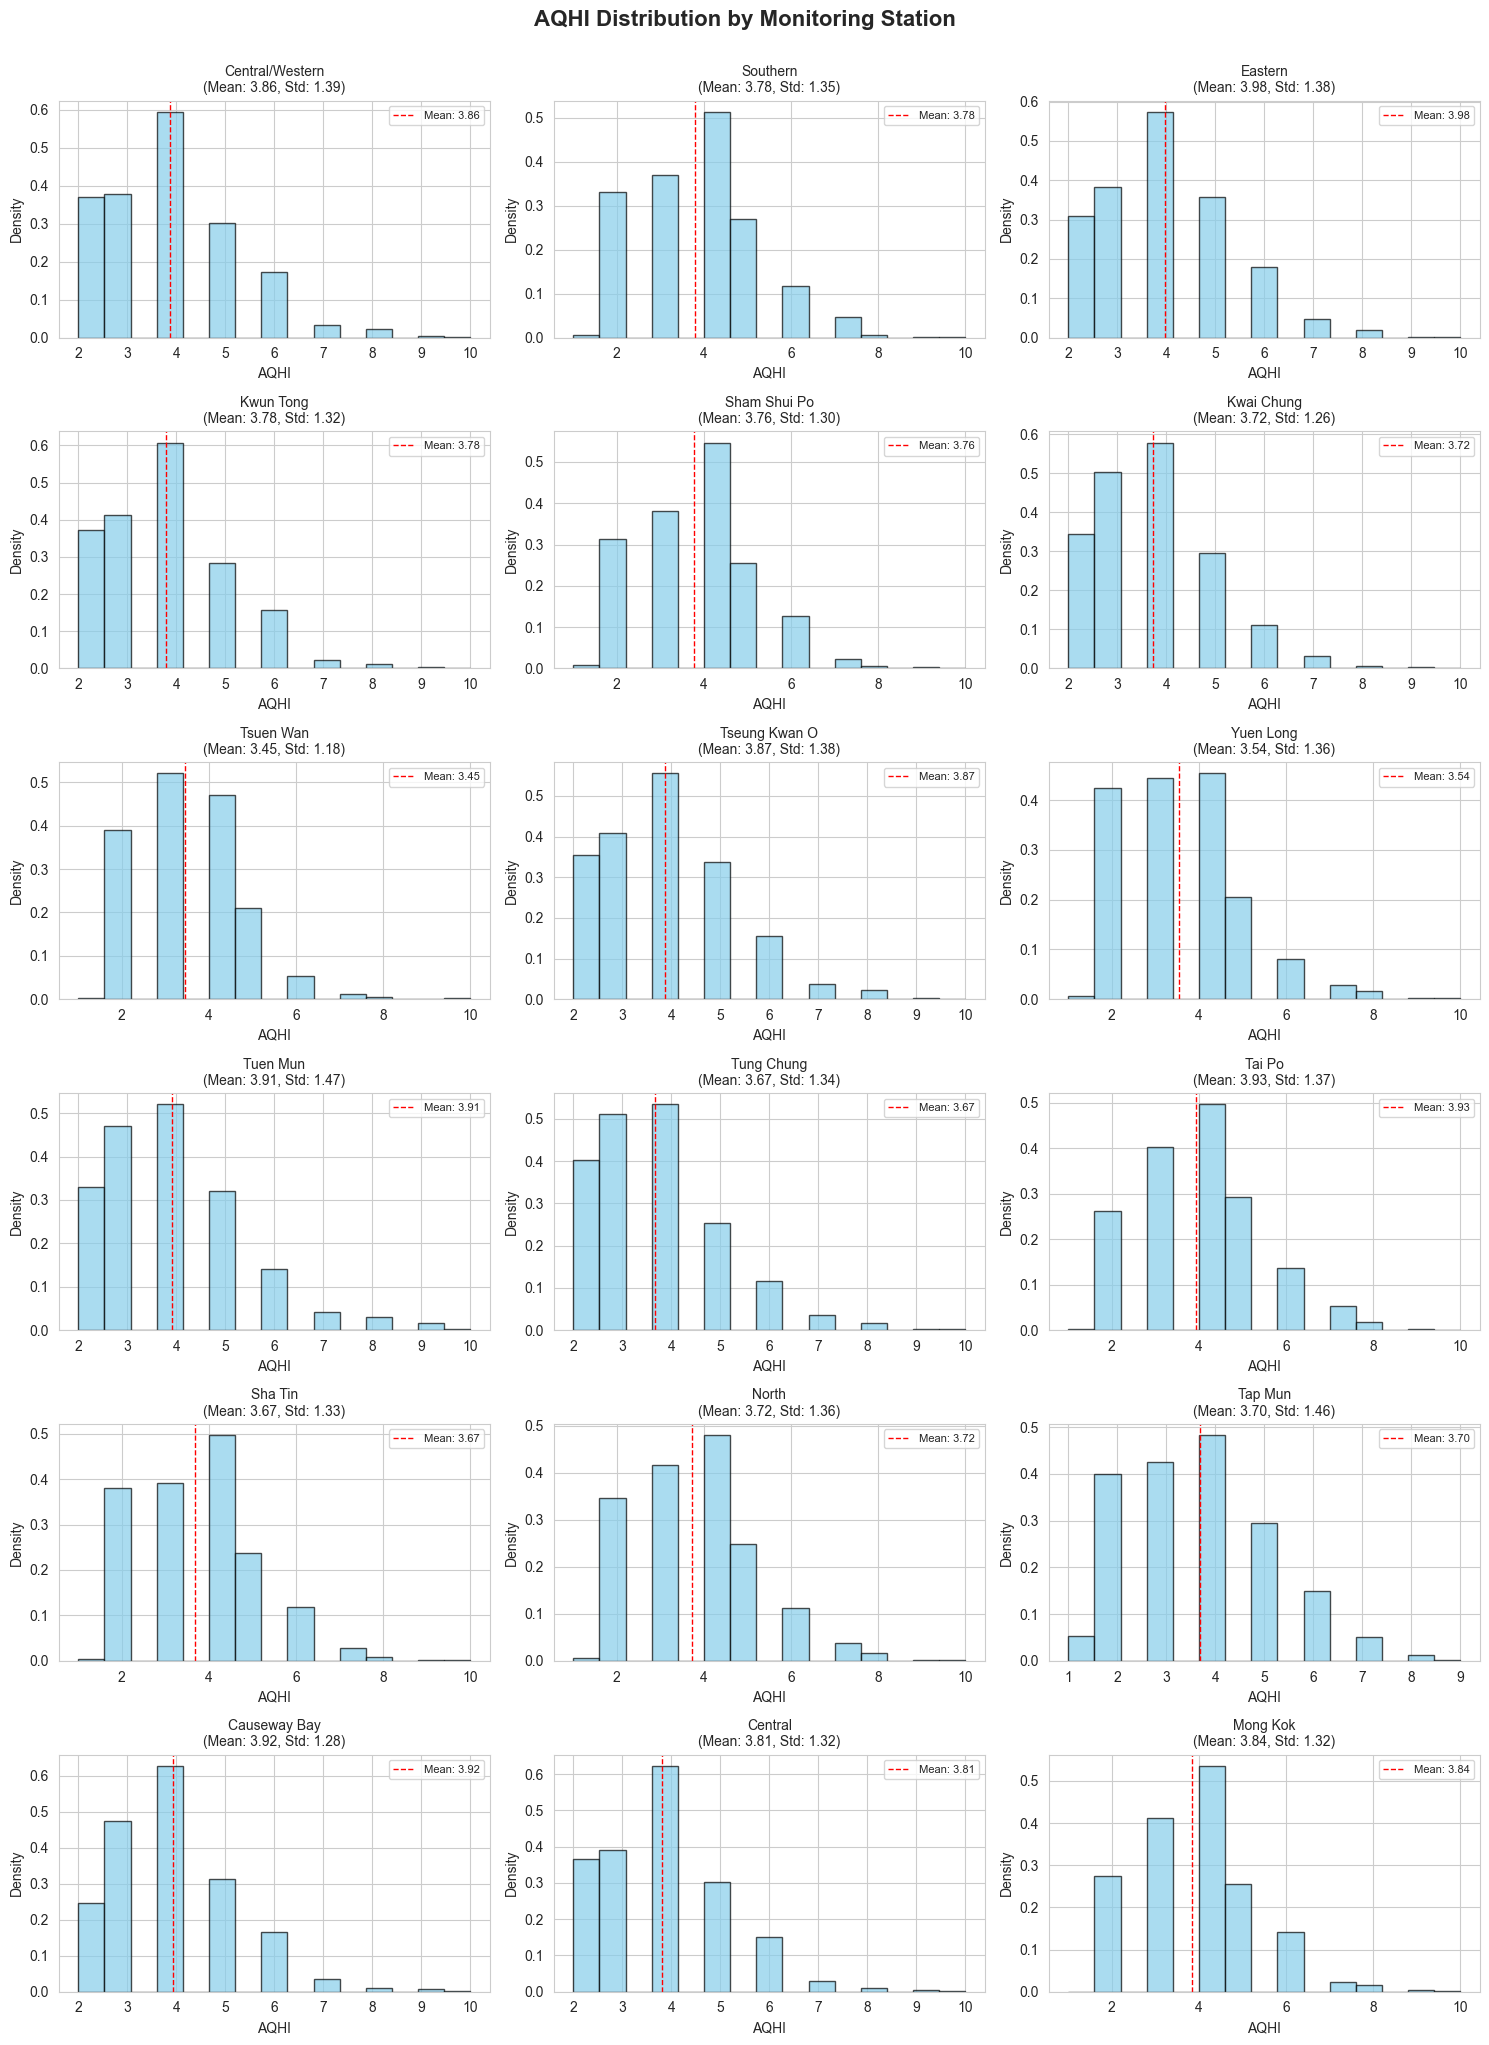

In [64]:
# 2.2 Distribution Visualization - Histograms and Density Plots
fig, axes = plt.subplots(6, 3, figsize=(15, 20))
axes = axes.ravel()

for i, station in enumerate(station_columns):
    data = df[station].dropna()
    axes[i].hist(
        data, bins=15, alpha=0.7, color="skyblue", edgecolor="black", density=True
    )
    axes[i].set_title(
        f"{station}\n(Mean: {data.mean():.2f}, Std: {data.std():.2f})", fontsize=10
    )
    axes[i].set_xlabel("AQHI")
    axes[i].set_ylabel("Density")

    # Add vertical line for mean
    axes[i].axvline(
        data.mean(),
        color="red",
        linestyle="--",
        linewidth=1,
        label=f"Mean: {data.mean():.2f}",
    )
    axes[i].legend(fontsize=8)

# Hide empty subplots
for j in range(len(station_columns), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.suptitle(
    "AQHI Distribution by Monitoring Station", y=1.02, fontsize=16, fontweight="bold"
)
plt.show()

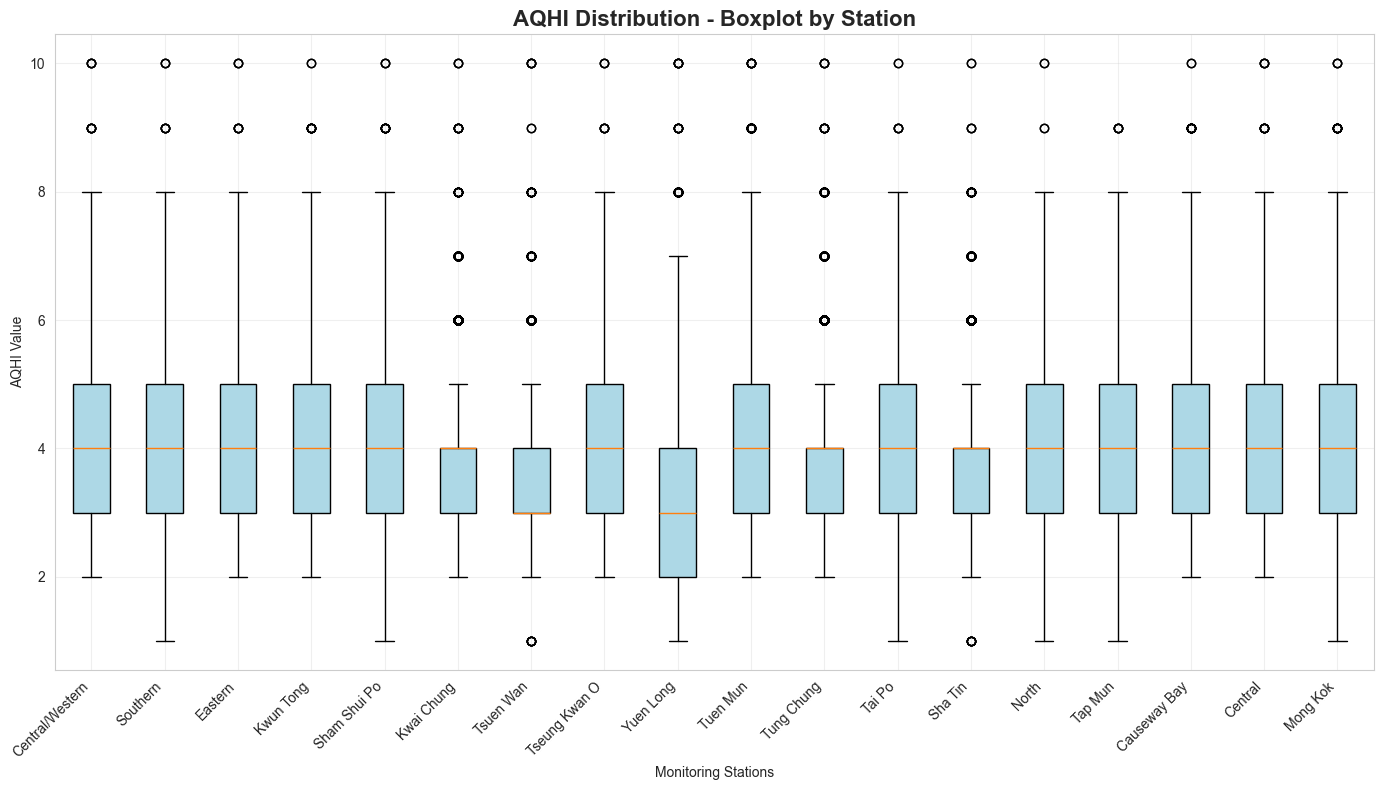

In [65]:
# 2.3 Boxplot Visualization for all stations
plt.figure(figsize=(14, 8))
box_data = [df[station].dropna() for station in station_columns]
box_plot = plt.boxplot(box_data, labels=station_columns, patch_artist=True)

# Customize boxplot
colors = ["lightblue"] * len(station_columns)
for patch, color in zip(box_plot["boxes"], colors):
    patch.set_facecolor(color)

plt.title("AQHI Distribution - Boxplot by Station", fontsize=16, fontweight="bold")
plt.xlabel("Monitoring Stations")
plt.ylabel("AQHI Value")
plt.xticks(rotation=45, ha="right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [66]:
# 2.4 Statistical Distribution Analysis
print("Distribution Analysis - Skewness and Kurtosis:")
print("=" * 50)

distribution_stats = []
for station in station_columns:
    data = df[station].dropna()
    skewness = data.skew()
    kurtosis = data.kurtosis()

    # Interpret skewness
    if abs(skewness) < 0.5:
        skew_type = "Approx symmetric"
    elif skewness > 0:
        skew_type = "Right skewed"
    else:
        skew_type = "Left skewed"

    # Interpret kurtosis
    if kurtosis > 1:
        kurt_type = "Leptokurtic (peaked)"
    elif kurtosis < -1:
        kurt_type = "Platykurtic (flat)"
    else:
        kurt_type = "Mesokurtic (normal)"

    distribution_stats.append(
        {
            "Station": station,
            # 偏度
            "Skewness": round(skewness, 3),
            "Skew Type": skew_type,
            "Kurtosis": round(kurtosis, 3),
            "Kurt Type": kurt_type,
        }
    )

dist_df = pd.DataFrame(distribution_stats)
print(dist_df.to_string(index=False))

Distribution Analysis - Skewness and Kurtosis:
        Station  Skewness        Skew Type  Kurtosis            Kurt Type
Central/Western     0.586     Right skewed     0.361  Mesokurtic (normal)
       Southern     0.550     Right skewed     0.240  Mesokurtic (normal)
        Eastern     0.481 Approx symmetric     0.140  Mesokurtic (normal)
      Kwun Tong     0.589     Right skewed     0.427  Mesokurtic (normal)
   Sham Shui Po     0.560     Right skewed     0.542  Mesokurtic (normal)
     Kwai Chung     0.658     Right skewed     0.693  Mesokurtic (normal)
      Tsuen Wan     0.830     Right skewed     1.494 Leptokurtic (peaked)
  Tseung Kwan O     0.579     Right skewed     0.300  Mesokurtic (normal)
      Yuen Long     0.956     Right skewed     1.321 Leptokurtic (peaked)
       Tuen Mun     0.901     Right skewed     1.119 Leptokurtic (peaked)
     Tung Chung     0.844     Right skewed     0.920  Mesokurtic (normal)
         Tai Po     0.585     Right skewed     0.216  Mesokurtic 

# 阶段三: 多变量分析与时空分析

In [67]:
# 3.1.1 Calculate Correlation Matrix
correlation_matrix = df[station_columns].corr()

print("Correlation Matrix Overview:")
print("=" * 50)
print(
    f"Correlation range: {correlation_matrix.values.min():.3f} to {correlation_matrix.values.max():.3f}"
)
print(f"Average correlation: {correlation_matrix.values.mean():.3f}")

# Display highest and lowest correlations
corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        corr_pairs.append(
            {
                "Station1": correlation_matrix.columns[i],
                "Station2": correlation_matrix.columns[j],
                "Correlation": correlation_matrix.iloc[i, j],
            }
        )

corr_df = pd.DataFrame(corr_pairs)
top_5_high = corr_df.nlargest(5, "Correlation")
top_5_low = corr_df.nsmallest(5, "Correlation")

print("\nTop 5 Highest Correlations:")
print(top_5_high.to_string(index=False))
print("\nTop 5 Lowest Correlations:")
print(top_5_low.to_string(index=False))

Correlation Matrix Overview:
Correlation range: 0.839 to 1.000
Average correlation: 0.914

Top 5 Highest Correlations:
       Station1     Station2  Correlation
Central/Western      Central     0.959805
Central/Western    Kwun Tong     0.957615
   Sham Shui Po     Mong Kok     0.957413
      Kwun Tong Sham Shui Po     0.956274
      Kwun Tong     Mong Kok     0.953813

Top 5 Lowest Correlations:
       Station1     Station2  Correlation
        Tap Mun      Central     0.838526
        Tap Mun Causeway Bay     0.844911
       Tuen Mun      Tap Mun     0.846691
Central/Western      Tap Mun     0.849305
        Tap Mun     Mong Kok     0.852012


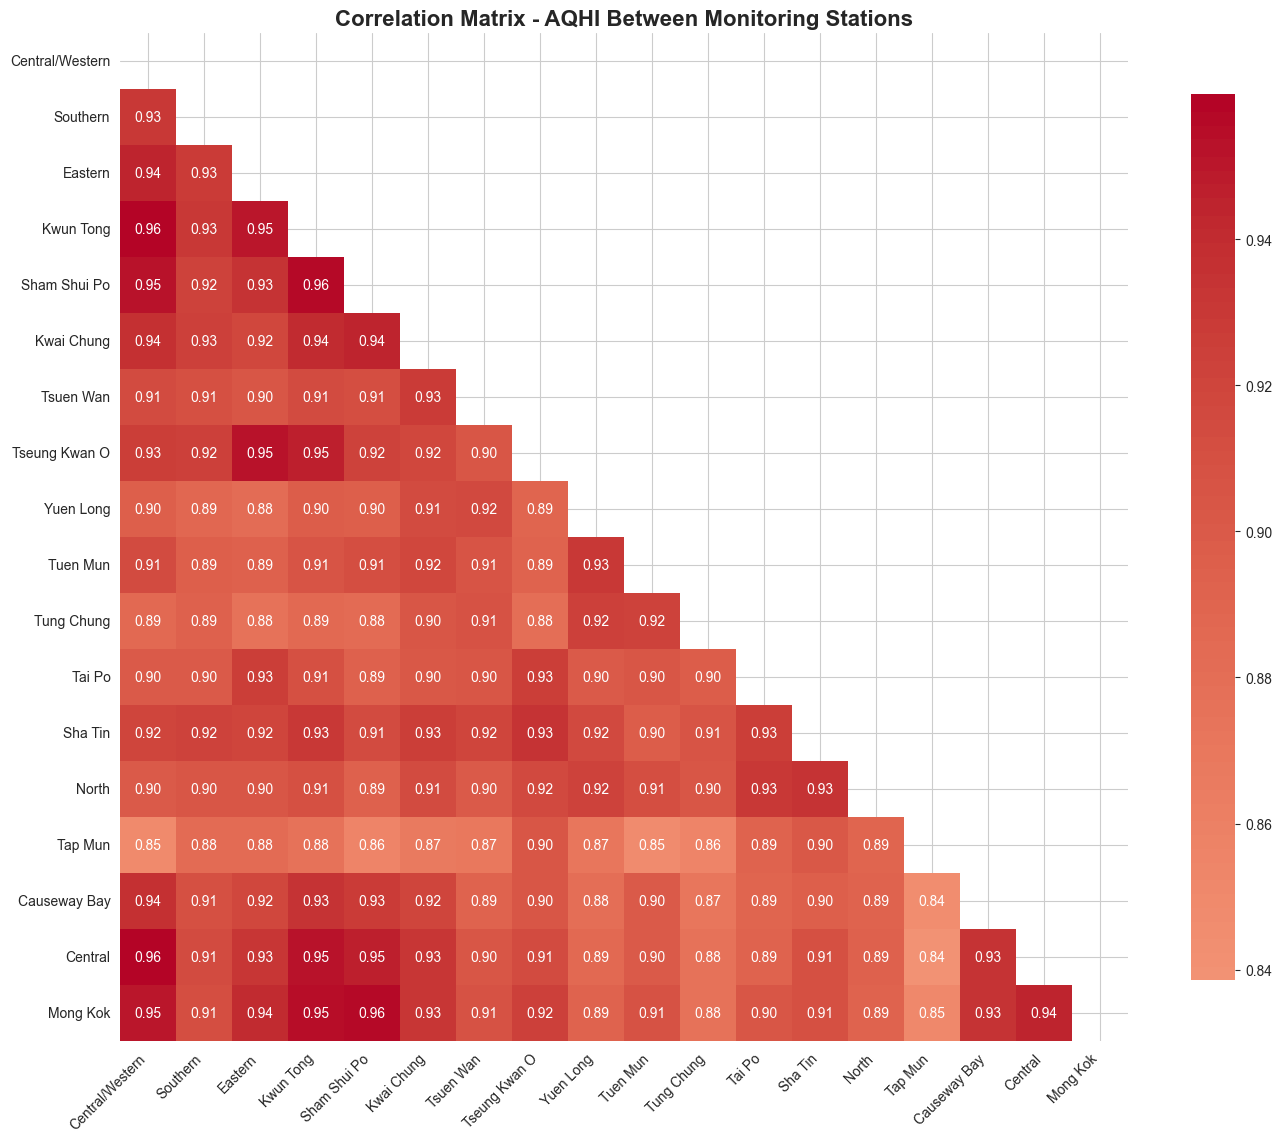

In [68]:
# 3.1.2 Correlation Heatmap Visualization
plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))  # Mask upper triangle
sns.heatmap(
    correlation_matrix,
    mask=mask,
    annot=True,
    cmap="coolwarm",
    center=0.7,
    square=True,
    fmt=".2f",
    cbar_kws={"shrink": 0.8},
)
plt.title(
    "Correlation Matrix - AQHI Between Monitoring Stations",
    fontsize=16,
    fontweight="bold",
)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

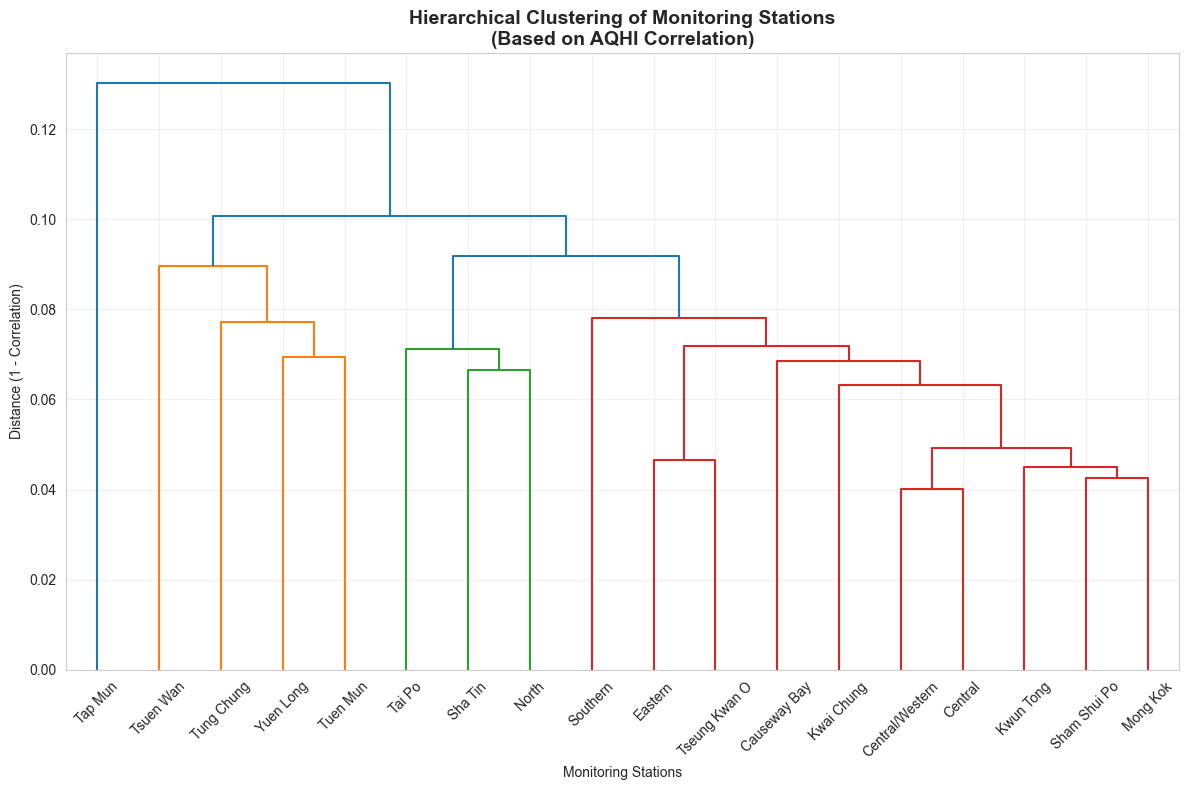

In [69]:
# 3.1.3 Cluster Analysis based on Correlation
from scipy.cluster import hierarchy

# Perform hierarchical clustering
plt.figure(figsize=(12, 8))
corr_condensed = hierarchy.distance.squareform(1 - correlation_matrix)
Z = hierarchy.linkage(corr_condensed, method="average")
hierarchy.dendrogram(
    Z, labels=station_columns, orientation="top", leaf_rotation=45, leaf_font_size=10
)
plt.title(
    "Hierarchical Clustering of Monitoring Stations\n(Based on AQHI Correlation)",
    fontsize=14,
    fontweight="bold",
)
plt.xlabel("Monitoring Stations")
plt.ylabel("Distance (1 - Correlation)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [80]:
# 3.2.1 Calculate Station Rankings
station_means = stats_df.set_index("Station")["Mean"].sort_values(ascending=False)

print("Station Ranking by Average AQHI (Highest to Lowest):")
print("=" * 55)
for i, (station, mean_aqhi) in enumerate(station_means.items(), 1):
    print(f"{i:2d}. {station:<20}: {mean_aqhi:.3f}")

# Identify best and worst stations
worst_5 = station_means.head(5)
best_5 = station_means.tail(5)

print(f"\n🚫 Worst 5 Stations (Highest AQHI):")
for station, mean_aqhi in worst_5.items():
    print(f"   {station:<20}: {mean_aqhi:.3f}")



print(f"\n✅ Best 5 Stations (Lowest AQHI):")
for station, mean_aqhi in best_5.items():
    print(f"   {station:<20}: {mean_aqhi:.3f}")

Station Ranking by Average AQHI (Highest to Lowest):
 1. Eastern             : 3.980
 2. Tai Po              : 3.927
 3. Causeway Bay        : 3.924
 4. Tuen Mun            : 3.906
 5. Tseung Kwan O       : 3.866
 6. Central/Western     : 3.863
 7. Mong Kok            : 3.842
 8. Central             : 3.806
 9. Southern            : 3.783
10. Kwun Tong           : 3.782
11. Sham Shui Po        : 3.764
12. North               : 3.721
13. Kwai Chung          : 3.719
14. Tap Mun             : 3.696
15. Tung Chung          : 3.669
16. Sha Tin             : 3.668
17. Yuen Long           : 3.542
18. Tsuen Wan           : 3.447

🚫 Worst 5 Stations (Highest AQHI):
   Eastern             : 3.980
   Tai Po              : 3.927
   Causeway Bay        : 3.924
   Tuen Mun            : 3.906
   Tseung Kwan O       : 3.866

✅ Best 5 Stations (Lowest AQHI):
   Tap Mun             : 3.696
   Tung Chung          : 3.669
   Sha Tin             : 3.668
   Yuen Long           : 3.542
   Tsuen Wan          

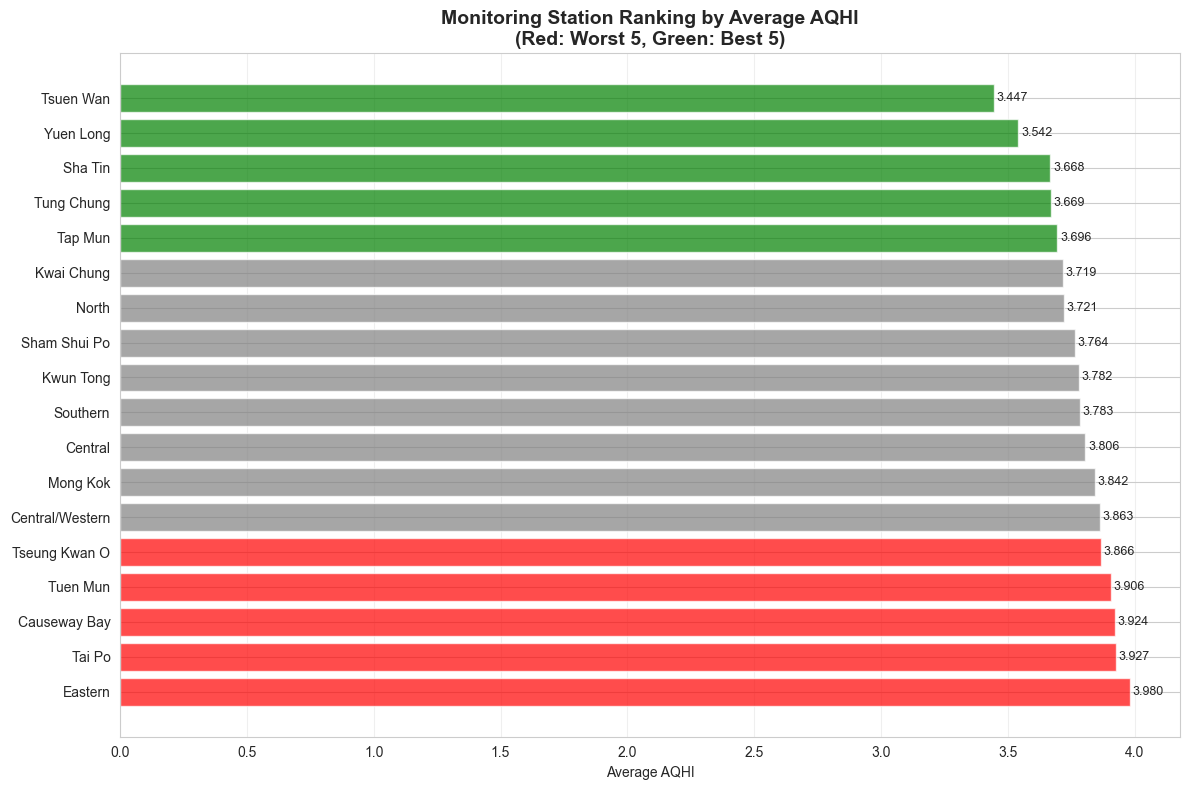

In [71]:
# 3.2.2 Visualization of Station Rankings
plt.figure(figsize=(12, 8))
colors = [
    "red" if x in worst_5.index else "green" if x in best_5.index else "gray"
    for x in station_means.index
]

bars = plt.barh(
    range(len(station_means)), station_means.values, color=colors, alpha=0.7
)
plt.yticks(range(len(station_means)), station_means.index)
plt.xlabel("Average AQHI")
plt.title(
    "Monitoring Station Ranking by Average AQHI\n(Red: Worst 5, Green: Best 5)",
    fontsize=14,
    fontweight="bold",
)
plt.grid(True, alpha=0.3, axis="x")

# Add value labels on bars
for i, bar in enumerate(bars):
    plt.text(
        bar.get_width() + 0.01,
        bar.get_y() + bar.get_height() / 2,
        f"{station_means.values[i]:.3f}",
        ha="left",
        va="center",
        fontsize=9,
    )

plt.tight_layout()
plt.show()

In [72]:
# 3.3.1 Daily Aggregation and Trend Analysis
# Calculate daily averages
df["Date_only"] = df["DateTime"].dt.date
daily_avg = df.groupby("Date_only")[station_columns].mean()

print("Daily AQHI Statistics:")
print("=" * 40)
print(f"Date range: {daily_avg.index.min()} to {daily_avg.index.max()}")
print(f"Overall daily average: {daily_avg.values.mean():.3f}")
print(f"Highest daily average: {daily_avg.values.max():.3f}")
print(f"Lowest daily average: {daily_avg.values.min():.3f}")

# Find best and worst days
daily_overall = daily_avg.mean(axis=1)
worst_days = daily_overall.nlargest(5)
best_days = daily_overall.nsmallest(5)

print(f"\n📈 Worst 5 Days (Highest Average AQHI):")
for date, aqhi in worst_days.items():
    print(f"   {date}: {aqhi:.3f}")

print(f"\n📉 Best 5 Days (Lowest Average AQHI):")
for date, aqhi in best_days.items():
    print(f"   {date}: {aqhi:.3f}")

Daily AQHI Statistics:
Date range: 2025-01-01 to 2025-06-01
Overall daily average: 3.780
Highest daily average: 8.789
Lowest daily average: 1.480

📈 Worst 5 Days (Highest Average AQHI):
   2025-04-14: 7.478
   2025-04-15: 7.196
   2025-04-13: 6.956
   2025-04-16: 6.013
   2025-02-18: 5.896

📉 Best 5 Days (Lowest Average AQHI):
   2025-04-21: 2.022
   2025-05-18: 2.029
   2025-05-20: 2.033
   2025-03-30: 2.044
   2025-03-31: 2.053


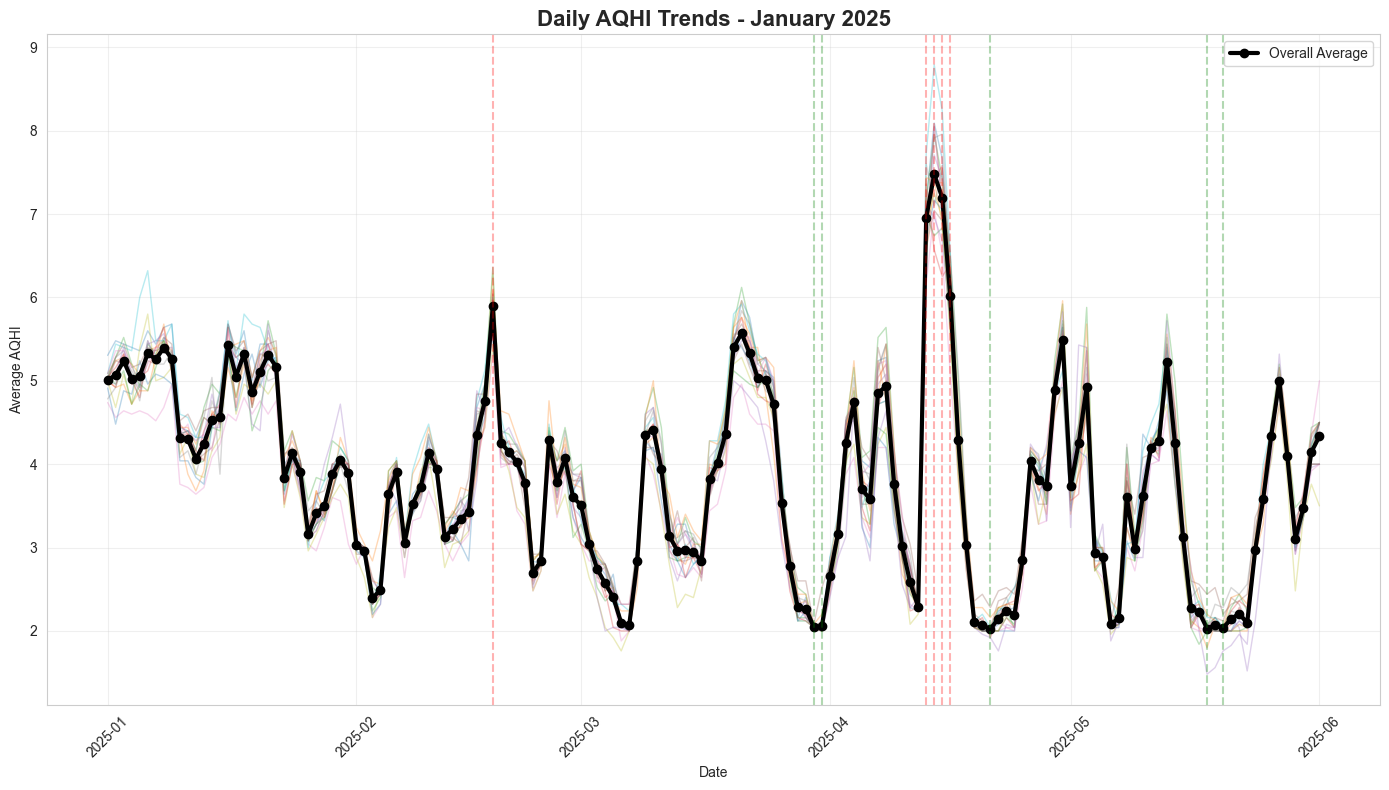

In [73]:
# 3.3.2 Time Series Visualization
plt.figure(figsize=(14, 8))

# Plot daily average for all stations
for station in station_columns:
    plt.plot(daily_avg.index, daily_avg[station], alpha=0.3, linewidth=1)

# Plot overall daily average
plt.plot(
    daily_avg.index,
    daily_overall,
    color="black",
    linewidth=3,
    label="Overall Average",
    marker="o",
)

plt.title("Daily AQHI Trends - January 2025", fontsize=16, fontweight="bold")
plt.xlabel("Date")
plt.ylabel("Average AQHI")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

# Highlight best and worst days
for date in worst_days.index:
    plt.axvline(x=date, color="red", alpha=0.3, linestyle="--")
for date in best_days.index:
    plt.axvline(x=date, color="green", alpha=0.3, linestyle="--")

plt.tight_layout()
plt.show()

Hourly AQHI Pattern Analysis:
Peak AQHI hour: 17:00 (AQHI: 4.219)
Lowest AQHI hour: 08:00 (AQHI: 3.312)
Daily amplitude: 0.908


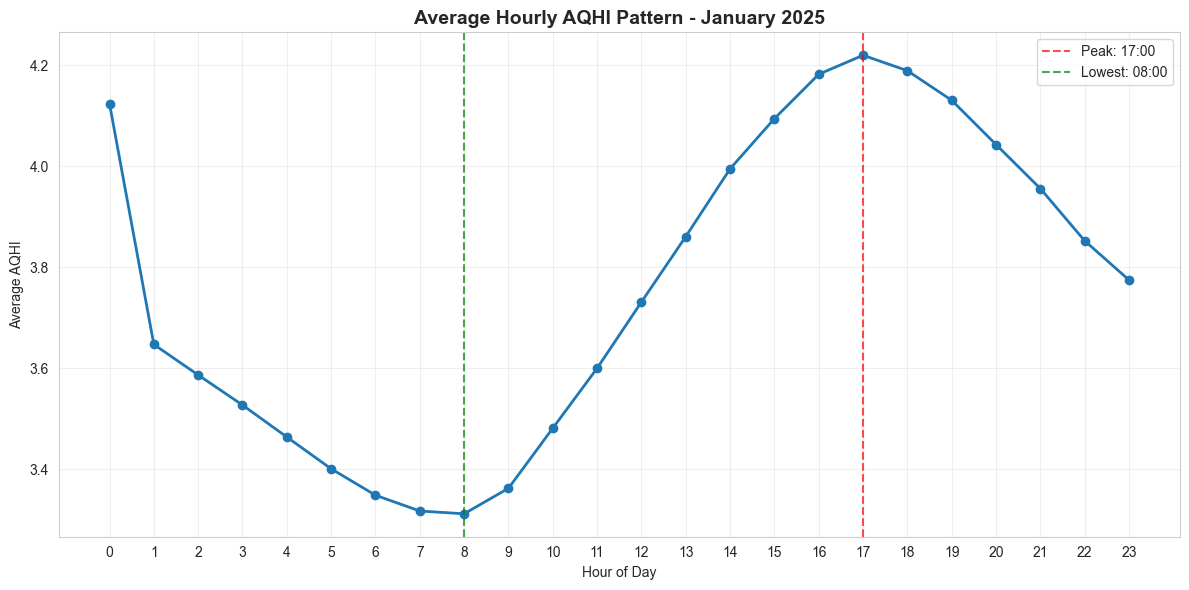

In [74]:
# 3.3.3 Hourly Pattern Analysis
df["Hour"] = df["DateTime"].dt.hour
hourly_avg = df.groupby("Hour")[station_columns].mean()
hourly_overall = hourly_avg.mean(axis=1)

print("Hourly AQHI Pattern Analysis:")
print("=" * 40)
peak_hour = hourly_overall.idxmax()
trough_hour = hourly_overall.idxmin()

print(f"Peak AQHI hour: {peak_hour:02d}:00 (AQHI: {hourly_overall.max():.3f})")
print(f"Lowest AQHI hour: {trough_hour:02d}:00 (AQHI: {hourly_overall.min():.3f})")
print(f"Daily amplitude: {hourly_overall.max() - hourly_overall.min():.3f}")

plt.figure(figsize=(12, 6))
plt.plot(hourly_avg.index, hourly_overall.values, marker="o", linewidth=2, markersize=6)
plt.title("Average Hourly AQHI Pattern - January 2025", fontsize=14, fontweight="bold")
plt.xlabel("Hour of Day")
plt.ylabel("Average AQHI")
plt.xticks(range(0, 24))
plt.grid(True, alpha=0.3)

# Highlight peak and trough
plt.axvline(
    x=peak_hour,
    color="red",
    linestyle="--",
    alpha=0.7,
    label=f"Peak: {peak_hour:02d}:00",
)
plt.axvline(
    x=trough_hour,
    color="green",
    linestyle="--",
    alpha=0.7,
    label=f"Lowest: {trough_hour:02d}:00",
)
plt.legend()

plt.tight_layout()
plt.show()

In [81]:
# 3.4.1 Weekday/Weekend Comparison
df["Weekday"] = df["DateTime"].dt.day_name()
df["Is_Weekend"] = df["DateTime"].dt.dayofweek >= 5  # 5=Saturday, 6=Sunday

weekday_avg = df[~df["Is_Weekend"]][station_columns].mean()
weekend_avg = df[df["Is_Weekend"]][station_columns].mean()

comparison = pd.DataFrame(
    {
        "Weekday_Avg": weekday_avg,
        "Weekend_Avg": weekend_avg,
        "Difference": weekend_avg - weekday_avg,
    }
).round(3)

print("Weekday vs Weekend AQHI Comparison:")
print("=" * 50)
print(comparison.sort_values("Difference", ascending=False))

overall_weekday = weekday_avg.mean()
overall_weekend = weekend_avg.mean()
print(f"\nOverall Average:")
print(f"Weekday: {overall_weekday:.3f}")
print(f"Weekend: {overall_weekend:.3f}")
print(f"Difference: {overall_weekend - overall_weekday:.3f}")

Weekday vs Weekend AQHI Comparison:
                 Weekday_Avg  Weekend_Avg  Difference
Yuen Long              3.574        3.461      -0.114
Tsuen Wan              3.485        3.351      -0.134
Tuen Mun               3.946        3.806      -0.140
Sha Tin                3.711        3.560      -0.151
Tung Chung             3.713        3.558      -0.155
Central/Western        3.907        3.752      -0.155
Causeway Bay           3.969        3.811      -0.158
North                  3.767        3.607      -0.160
Tap Mun                3.750        3.564      -0.186
Central                3.861        3.670      -0.190
Kwun Tong              3.839        3.640      -0.200
Mong Kok               3.899        3.699      -0.200
Southern               3.841        3.637      -0.204
Kwai Chung             3.778        3.571      -0.207
Tseung Kwan O          3.928        3.712      -0.215
Sham Shui Po           3.826        3.610      -0.216
Tai Po                 3.993        3.762     